# Inverting Gradients - How easy is it to break privacy in federated learning?

This notebook shows an example for a **small-batch image gradient inversion** as described in "Inverting Gradients - How easy is it to break privacy in federated learning?". The setting is a trained ResNet-18 and the federated learning algorithm is **fedAVG**.

Paper URL: https://proceedings.neurips.cc/paper/2020/hash/c4ede56bbd98819ae6112b20ac6bf145-Abstract.html

This notebook can replicate the experiments in Fig.5 and Tab. 2 of this paper.

#### Abstract
The idea of federated learning is to collaboratively train a neural network on a server. Each user receives the current weights of the network and in turns sends parameter updates (gradients) based on local data. This protocol has been designed not only to train neural networks data-efficiently, but also to provide privacy benefits for users, as their input data remains on device and only parameter gradients are shared. But how secure is sharing parameter gradients? Previous attacks have provided a false sense of security, by succeeding only in contrived settings - even for a single image. However, by exploiting a magnitude-invariant loss along with optimization strategies based on adversarial attacks, we show that is is actually possible to faithfully reconstruct images at high resolution from the knowledge of their parameter gradients, and demonstrate that such a break of privacy is possible even for trained deep networks. We analyze the effects of architecture as well as parameters on the difficulty of reconstructing an input image and prove that any input to a fully connected layer can be reconstructed analytically independent of the remaining architecture. Finally we discuss settings encountered in practice and show that even averaging gradients over several iterations or several images does not protect the user's privacy in federated learning applications.

### Startup

In [1]:
import numpy as np
import torch

seed = 47
np.random.seed(seed)
torch.manual_seed(seed)

In [2]:
try:
    import breaching
except ModuleNotFoundError:
    # You only really need this safety net if you want to run these notebooks directly in the examples directory
    # Don't worry about this if you installed the package or moved the notebook to the main directory.
    import os; os.chdir("..")
    import breaching
    
    
import torch
%load_ext autoreload
%autoreload 2

# Redirects logs directly into the jupyter notebook
import logging, sys
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/kfac/base_preconditioner.py:15: UserWarning: NVIDIA Apex is not installed or was not installed with --cpp_ext. Falling back to PyTorch flatten and unflatten.
  from kfac.distributed import get_rank


### Initialize cfg object and system setup:

This will load the full configuration object. This includes the configuration for the use case and threat model as `cfg.case` and the hyperparameters and implementation of the attack as `cfg.attack`. All parameters can be modified below, or overriden with `overrides=` as if they were cmd-line arguments.

In [3]:
cfg = breaching.get_config(overrides=["case=4_fedavg_small_scale", "case/data=CIFAR10"])
          
#device = torch.device(f'cuda:2') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("mps")
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case fedavg_small_scale with server type honest_but_curious.


{'device': device(type='mps'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations for the attack, or the case:

In [4]:
cfg.case.data.partition="random"
cfg.case.user.user_idx = 1
cfg.case.model='resnet18'

cfg.case.user.provide_labels = True

# These settings govern the total amount of user data and how it is used over multiple local update steps:
cfg.case.user.num_data_points = 4
cfg.case.user.num_local_updates = 4
cfg.case.user.num_data_per_local_update_step = 2


# Total variation regularization needs to be smaller on CIFAR-10:
cfg.attack.regularization.total_variation.scale = 1e-3

### Instantiate all parties

The following lines generate "server, "user" and "attacker" objects and print an overview of their configurations.

In [5]:
user, server, model, loss_fn = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)
breaching.utils.overview(server, user, attacker)

Files already downloaded and verified
Model architecture resnet18 loaded with 11,173,962 parameters and 9,620 buffers.
Overall this is a data ratio of     909:1 for target shape [4, 3, 32, 32] given that num_queries=1.
User (of type UserMultiStep) with settings:
    Number of data points: 4

    Threat model:
    User provides labels: True
    User provides buffers: False
    User provides number of data points: True

    Data:
    Dataset: CIFAR10
    user: 1
    
        
    Local FL Setup:
        Number of local update steps: 4
        Data per local update step: 2
        Local learning rate: 0.001

        Threat model:
        Share these hyperparams to server: True

        
Server (of type HonestServer) with settings:
    Threat model: Honest-but-curious
    Number of planned queries: 1
    Has external/public data: False

    Model:
        model specification: resnet18
        model state: default
        public buffers: True

    Secrets: {}
    
Attacker (of type Optimiza

### Simulate an attacked FL protocol

This exchange is a simulation of a single query in a federated learning protocol. The server sends out a `server_payload` and the user computes an update based on their private local data. This user update is `shared_data` and contains, for example, the parameter gradient of the model in the simplest case. `true_user_data` is also returned by `.compute_local_updates`, but of course not forwarded to the server or attacker and only used for (our) analysis.

In [6]:
"""
Fix for this bug:

---------------------------------------------------------------------------
NotImplementedError                       Traceback (most recent call last)
Cell In[6], line 2
      1 server_payload = server.distribute_payload()
----> 2 shared_data, true_user_data = user.compute_local_updates(server_payload)

File /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/breaching/cases/users.py:387, in UserMultiStep.compute_local_updates(self, server_payload)
    385         self._clip_list_of_grad_(grads_ref)
    386     self._apply_differential_noise(grads_ref)
--> 387     preconditioner.step()
    388     optimizer.step()
    390 # Share differential to server version:
    391 # This is equivalent to sending the new stuff and letting the server do it, but in line
    392 # with the gradients sent in UserSingleStep

File /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torch/utils/_contextlib.py:115, in context_decorator.<locals>.decorate_context(*args, **kwargs)
    112 @functools.wraps(func)
    113 def decorate_context(*args, **kwargs):
    114     with ctx_factory():
--> 115         return func(*args, **kwargs)

File /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/kfac/base_preconditioner.py:343, in BaseKFACPreconditioner.step(self)
    341 for name, layer in reversed(list(self._layers.values())):
    342     if get_rank() == self._assignment.inv_worker(name, 'A'):
--> 343         layer.compute_a_inv(damping=self.damping)
    344     if (
    345         self._assignment.broadcast_inverses()
    346         and self._assignment.is_grad_worker(name)
    347     ):
    348         layer.broadcast_a_inv(
    349             src=self._assignment.inv_worker(name, 'A'),
    350             group=self._assignment.grad_worker_group(name),
    351         )

File /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/kfac/layers/eigen.py:310, in KFACEigenLayer.compute_a_inv(self, damping)
    305     raise RuntimeError(
    306         'Cannot eigendecompose A before A has been computed',
    307     )
    309 if self.symmetric_factors:
--> 310     self.da, self.qa = torch.linalg.eigh(
    311         self.a_factor.to(torch.float32),
    312     )
    313 else:
    314     da, qa = torch.linalg.eig(
    315         self.a_factor.to(torch.float32),
    316     )

NotImplementedError: The operator 'aten::_linalg_eigh.eigenvalues' is not currently implemented for the MPS device. If you want this op to be added in priority during the prototype phase of this feature, please comment on https://github.com/pytorch/pytorch/issues/77764. As a temporary fix, you can set the environment variable `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as a fallback for this op. WARNING: this will be slower than running natively on MPS.
"""

import os

# Set the environment variable
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '0'

# Verify the environment variable
print(os.environ['PYTORCH_ENABLE_MPS_FALLBACK'])

0


In [ ]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)

Using KFAC
Computing user update on user 1 in model mode: training.
blah2


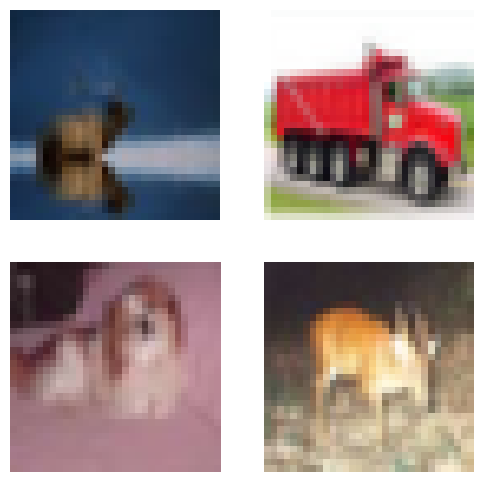

In [8]:
user.plot(true_user_data)

### Reconstruct user data:

Now we launch the attack, reconstructing user data based on only the `server_payload` and the `shared_data`. 

You can interrupt the computation early to see a partial solution.

In [ ]:
%%time
reconstructed_user_data, stats = attacker.reconstruct([server_payload], [shared_data], {}, dryrun=cfg.dryrun)

| It: 1 | Rec. loss: 1.0085 |  Task loss: 1.7728 | T: 1.19s


Next we'll evaluate metrics, comparing the `reconstructed_user_data` to the `true_user_data`.

In [14]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, [server_payload], 
                                    server.model, order_batch=True, compute_full_iip=False, 
                                    cfg_case=cfg.case, setup=setup)

Starting evaluations for attack effectiveness report...


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/breaching/analysis/metrics.py:24: UserWarning: To utilize wavelet SSIM, install pytorch wavelets from https://github.com/fbcotter/pytorch_wavelets.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib

Files already downloaded and verified


ConfigAttributeError: Key 'vocab_size' is not in struct
    full_key: case.data.vocab_size
    object_type=dict

And finally, we also plot the reconstructed data:

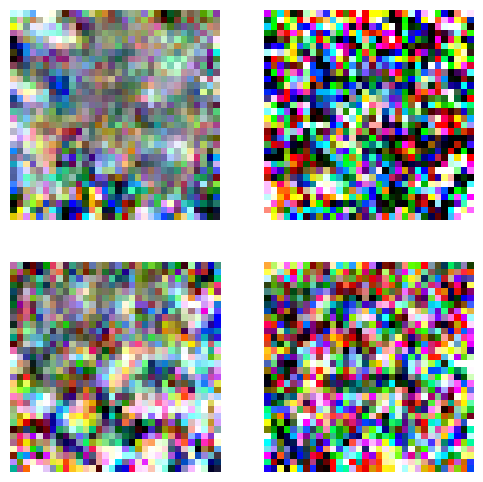

In [15]:
user.plot(reconstructed_user_data)

### Notes:
* If labels are unknown, then a robust label recovery algorithm has to be used that does not count label repetitions due to shifts after local updates.